# Código Python - Trabalho 2

## *Imports* estáticos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

## Declaração de variáveis repeditas

In [ ]:
random_state = 42
alpha = 0.05
test_size = 0.3

## 4.1  Análise Exploratória de Dados
### 4.1.1   Leitura do ficheiro

In [2]:
dados = pd.read_csv('dados/AIRPOL_data.csv', delimiter=";", header=0, decimal=',')
dados = dados.drop(columns=['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15']).rename(columns={"Value":"Premature_Deaths","Outcome":"Disease"})
#dados = dados[dados.Country != 'All Countries']
#dados.sort_values(by=['Value'])

#### Sumário dos dados

In [3]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49140 entries, 0 to 49139
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       49140 non-null  object 
 1   NUTS_Code                     49140 non-null  object 
 2   Air_Pollutant                 49140 non-null  object 
 3   Disease                       49140 non-null  object 
 4   Affected_Population           49140 non-null  float64
 5   Populated_Area[km2]           49140 non-null  float64
 6   Air_Pollution_Average[ug/m3]  49140 non-null  float64
 7   Premature_Deaths              49140 non-null  float64
dtypes: float64(4), object(4)
memory usage: 3.0+ MB
None


### 4.1.2   Exploração com gráficos

In [4]:
dados.describe()

,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Premature_Deaths
count,4.914000e+04,4.914000e+04,49140.000000,49140.000000
mean,1.023692e+06,6.534426e+03,15.138166,366.798657
std,9.085726e+06,5.661679e+04,22.579360,5494.481929
min,2.674000e+03,2.000000e+00,0.100000,0.000000
25%,1.069040e+05,5.697000e+02,7.200000,3.000000
50%,2.388280e+05,1.340100e+03,8.900000,23.000000
75%,5.988800e+05,4.215200e+03,11.400000,112.000000
max,4.680626e+08,2.687568e+06,125.700000,740933.000000


In [5]:
features = list(dados.columns[0:8])
print(features)

['Country', 'NUTS_Code', 'Air_Pollutant', 'Disease', 'Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Premature_Deaths']


In [6]:
numericFeatures = features[4:]
numericFeatures

['Affected_Population',
 'Populated_Area[km2]',
 'Air_Pollution_Average[ug/m3]',
 'Premature_Deaths']

#### Análise Univariável

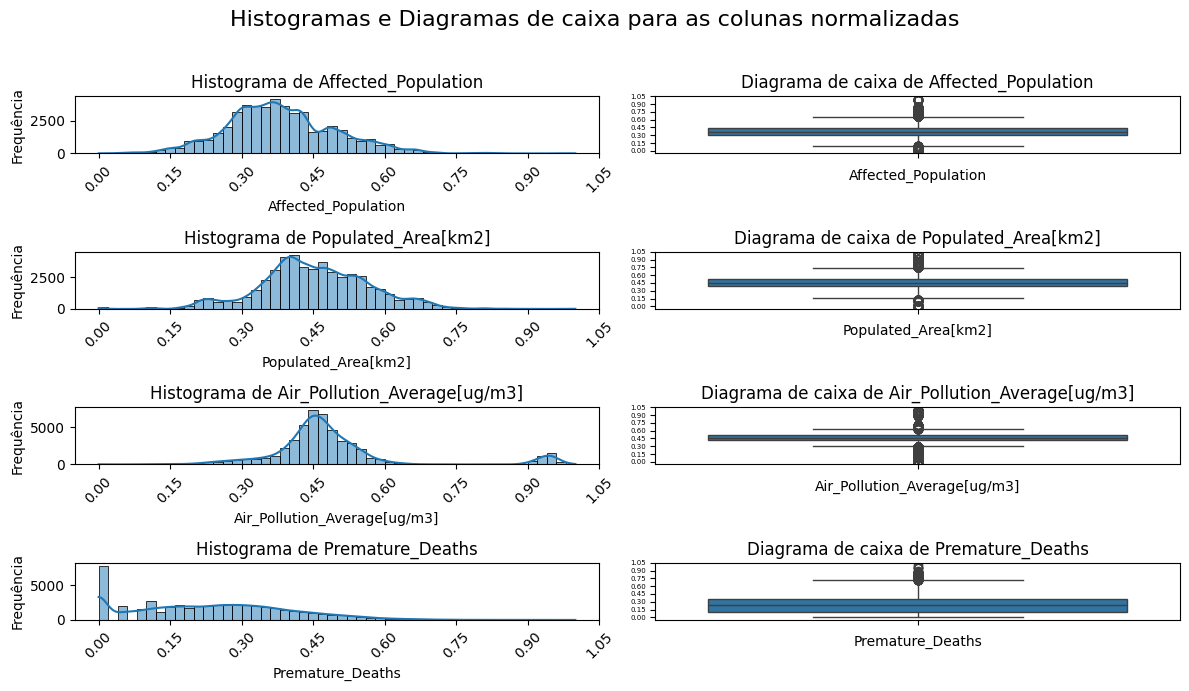

In [7]:
# Aplicar log1p (log(1 + x)) para reduzir o impacto de valores extremos
dados_log = dados[numericFeatures].apply(lambda x: np.log1p(x))

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
dados_scaled = pd.DataFrame(scaler.fit_transform(dados_log), columns=numericFeatures)

num_features = len(numericFeatures)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(12, 3 + num_features))
fig.suptitle("Histogramas e Diagramas de caixa para as colunas normalizadas", fontsize=16)

for i, column in enumerate(numericFeatures):

    sns.histplot(dados_scaled[column], ax=axes[i, 0], kde=True, bins=50)
    axes[i, 0].set_title(f"Histograma de {column}")
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel("Frequência")
    axes[i, 0].tick_params(axis='x', labelrotation=45)
    axes[i, 0].xaxis.set_major_locator(plt.MaxNLocator(10))

    sns.boxplot(y=dados_scaled[column], ax=axes[i, 1])
    axes[i, 1].set_title(f"Diagrama de caixa de {column}")
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel("")
    axes[i, 1].tick_params(axis='y', labelsize=5)
    axes[i, 1].yaxis.set_major_locator(plt.MaxNLocator(10))

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

#### Análise Bivariável

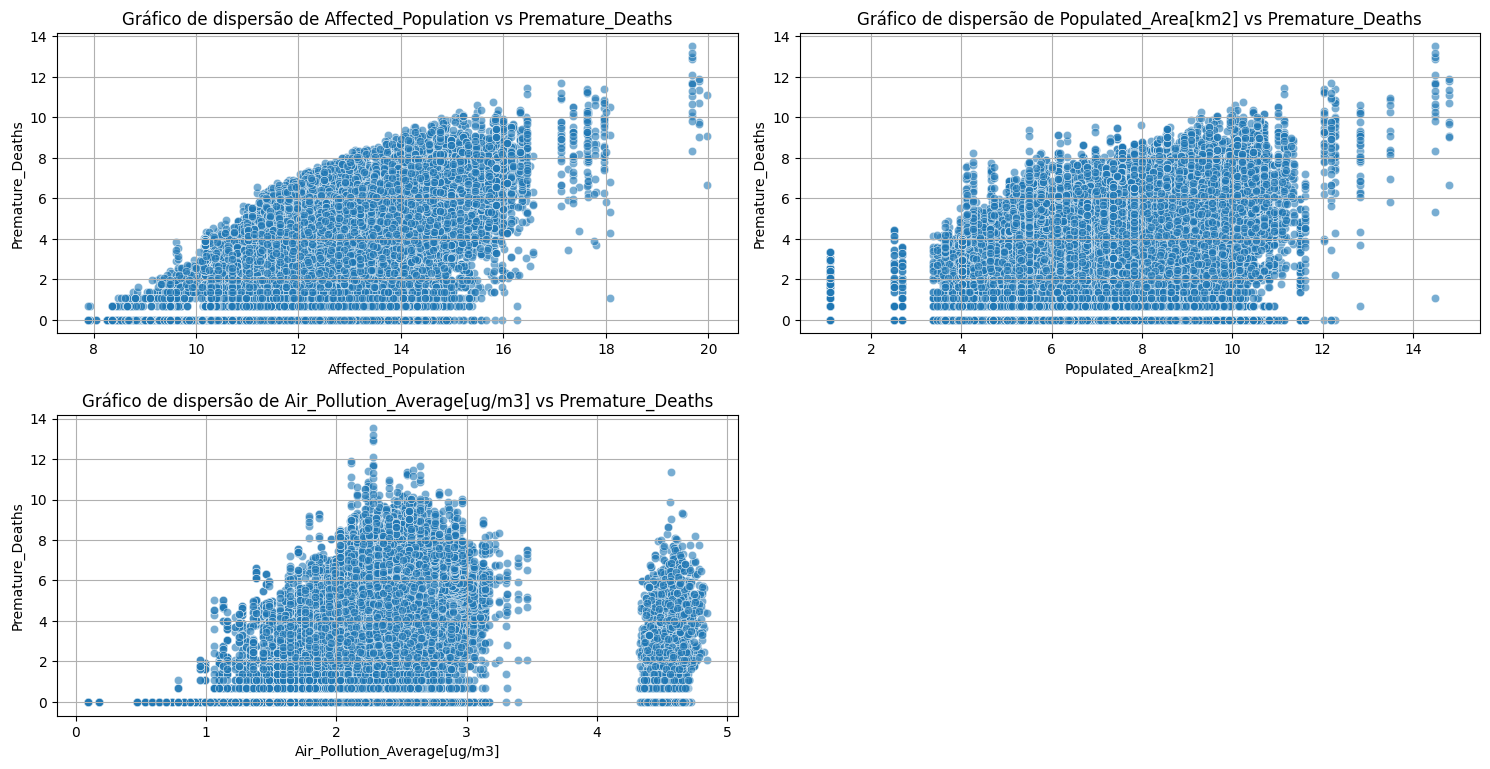

In [8]:
goalAttrib = 'Premature_Deaths'

plt.figure(figsize=(15,15))
numericFeaturesWOValue = [f for f in numericFeatures if f != goalAttrib]
for i, feature in enumerate(numericFeaturesWOValue):
    rows = (len(numericFeaturesWOValue) + 1) # Adjust rows to handle odd number of features
    plt.subplot(rows,2,i+1)
    sns.scatterplot(x=dados_log[feature], y=dados_log[goalAttrib], alpha=0.6)
    plt.title("Gráfico de dispersão de " + feature + " vs " + goalAttrib)
    plt.xlabel(feature)
    plt.ylabel(goalAttrib)
    plt.grid()
plt.tight_layout()

### 4.1.3. Pré-processamento dos dados

In [10]:
# Remover outliers
print(f"Número de linhas antes da remoção de outliers: {len(dados)}")

for col in numericFeatures:
    Q1 = dados[col].quantile(0.25)
    Q3 = dados[col].quantile(0.75)
    IQR = Q3 - Q1
    filtro = (dados[col] >= (Q1 - 1.5 * IQR)) & (dados[col] <= (Q3 + 1.5 * IQR))
    dados = dados[filtro]

print(f"Número de linhas após remoção de outliers: {len(dados)}")

Número de linhas antes da remoção de outliers: 49140
Número de linhas após remoção de outliers: 30917


### 4.1.4. Agrupamento dos dados em zonas

In [11]:
westEuDados = dados[dados['Country'].isin(['Austria', 'Belgium', 'France', 'Germany', 'Netherlands', 'Switzerland'])]
eastEuDados = dados[dados['Country'].isin(['Poland', 'Czechia', 'Hungary'])]
soutEuDados = dados[dados['Country'].isin(['Greece', 'Spain', 'Italy', 'Portugal'])]
nortEuDados = dados[dados['Country'].isin(['Sweden', 'Denmark', 'Northern Europe', 'Finland'])]

### 4.2.2 - Com o método k-fold cross validation obter um modelo de regressão linear simples para a variável Premature_Deaths usando a variável Affected_Population dos países do Southern Europe

In [12]:
goalAttr = soutEuDados.columns[7]
feature = soutEuDados.columns[4]

print(f"Goal attribute: {goalAttr}")
print(f"Feature: {feature}")

Goal attribute: Value
Feature: Affected_Population


#### Divisão dos dados (Holdout: 70% Train / 30% Test)

In [ ]:
from sklearn.model_selection import train_test_split

y = soutEuDados[goalAttr]
X = soutEuDados[[feature]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

print('Train set size: ' + str(X_train.shape) + "x_test_size" + str(X_test.shape))
print('Test set size: ' + str(y_train.shape) + "y_test_size" + str(y_test.shape))

Train set size: (3966, 1)x_test_size(1700, 1)
Test set size: (3966,)y_test_size(1700,)


### Modelo de Regressão Linear Simples

In [14]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

print(f"Função linear média: {goalAttr} = {np.round(lr.coef_, 8)} * {feature} + {np.round(lr.intercept_, 3)}")

Função linear média: Value = [5.349e-05] * Affected_Population + 16.639


#### Visualização da reta e da dispersão de dados de teste

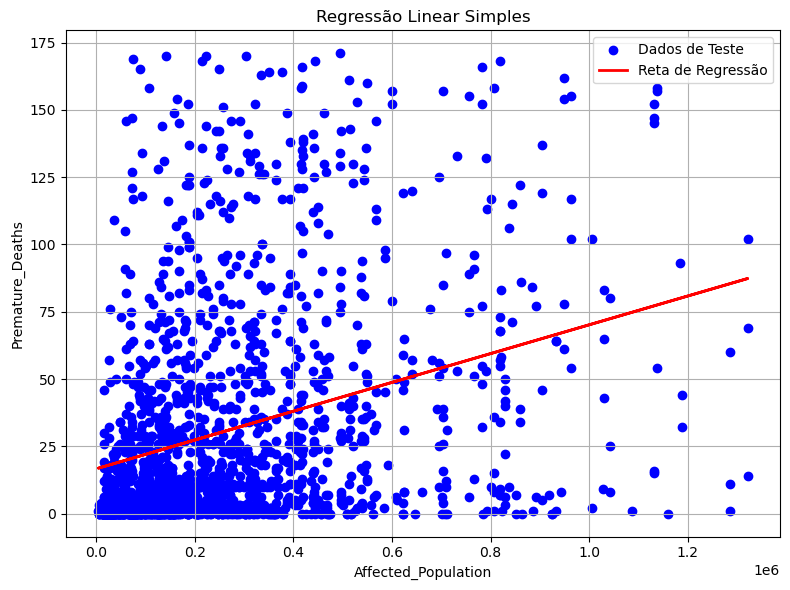

In [15]:
y_pred_test = lr.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Dados de Teste')
plt.plot(X_test, y_pred_test, color='red', linewidth=2, label='Reta de Regressão')
plt.xlabel('Affected_Population')
plt.ylabel('Premature_Deaths')
plt.title('Regressão Linear Simples')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

O gráfico apresentado mostra a relação entre a variável "Affected_Population" (população afetada) e "Premature_Deaths" (mortes prematuras) para os países do Sul da Europa, juntamente com a reta de regressão linear ajustada ao conjunto de teste.

Podemos observar que existe uma tendência positiva: à medida que a população afetada aumenta, o número de mortes prematuras também tende a aumentar. A reta de regressão representa a melhor aproximação linear dessa relação, de acordo com o modelo treinado.

No entanto, nota-se alguma dispersão dos pontos em torno da reta, indicando que outros fatores além da população afetada podem influenciar o número de mortes prematuras. Ainda assim, a reta ajustada sugere que a variável "Affected_Population" é um preditor relevante para "Premature_Deaths" neste contexto. 

A análise quantitativa dos erros (MAE e RMSE) nas próximas células ajudará a avaliar a precisão do modelo.

#### Calcular o MAE e o RMSE com o K-Fold Cross Validation

In [16]:
from sklearn.model_selection import cross_val_score, KFold

K = 10  # Número de folds
kFolds = KFold(n_splits=K, shuffle=True, random_state=42)

# MAE
mae_scores = cross_val_score(lr, X_train, y_train, cv=kFolds, scoring='neg_mean_absolute_error')
mae_mean = -np.mean(mae_scores)
mae_std = np.std(mae_scores)

# RMSE
mse_scores = cross_val_score(lr, X_train, y_train, cv=kFolds, scoring='neg_mean_squared_error')
rmse_scores = (-mse_scores) ** 0.5
rmse_mean = np.mean(rmse_scores)
rmse_std = np.std(rmse_scores)

print(f"MAE: {np.round(mae_mean, 3)} ± {np.round(mae_std, 3)}")
print(f"RMSE: {np.round(rmse_mean, 3)} ± {np.round(rmse_std, 3)}")

MAE: 28.491 ± 1.483
RMSE: 38.069 ± 2.176


Os valores de MAE e RMSE apresentados indicam o desempenho do modelo de regressão linear simples ao prever "Premature_Deaths" com base em "Affected_Population" para os países do Sul da Europa. Se ambos os valores forem baixos e próximos entre si, isso sugere que o modelo apresenta boa precisão e que os erros de previsão não são significativamente influenciados por grandes outliers. Por outro lado, se o RMSE for consideravelmente maior que o MAE, isso indica que existem alguns pontos com erros elevados, o que pode ser resultado de dispersão ou outliers nos dados. De modo geral, quanto menores forem esses valores, melhor será o ajuste do modelo aos dados observados, reforçando a relação linear identificada no gráfico.


### 4.2.3 K-Fold cross validation
#### Otimização dos parâmetros da Árvore de regressão e visualização

In [ ]:
results = []
for max_depth in range(2, 11):
    for min_samples_split in [2, 5, 10]:
        for min_samples_leaf in [1, 2, 4]:
            dt = DecisionTreeRegressor(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=random_state
            )
            dt.fit(X_train, y_train)
            y_pred = dt.predict(X_test)

            result = {
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'mse': mean_squared_error(y_test, y_pred),
                'r2': r2_score(y_test, y_pred)
            }
            results.append(result)

resdf = pd.DataFrame(results)
resdf = resdf.sort_values(by='r2', ascending=False)
resdf

,max_depth,min_samples_split,min_samples_leaf,mse,r2
66,9,5,1,4.240477e+06,0.486007
64,9,2,2,4.241367e+06,0.485899
67,9,5,2,4.241379e+06,0.485897
63,9,2,1,4.241646e+06,0.485865
58,8,5,2,4.248278e+06,0.485061
...,...,...,...,...,...
4,2,5,2,5.298347e+06,0.357781
5,2,5,4,5.298347e+06,0.357781
6,2,10,1,5.298347e+06,0.357781
7,2,10,2,5.298347e+06,0.357781


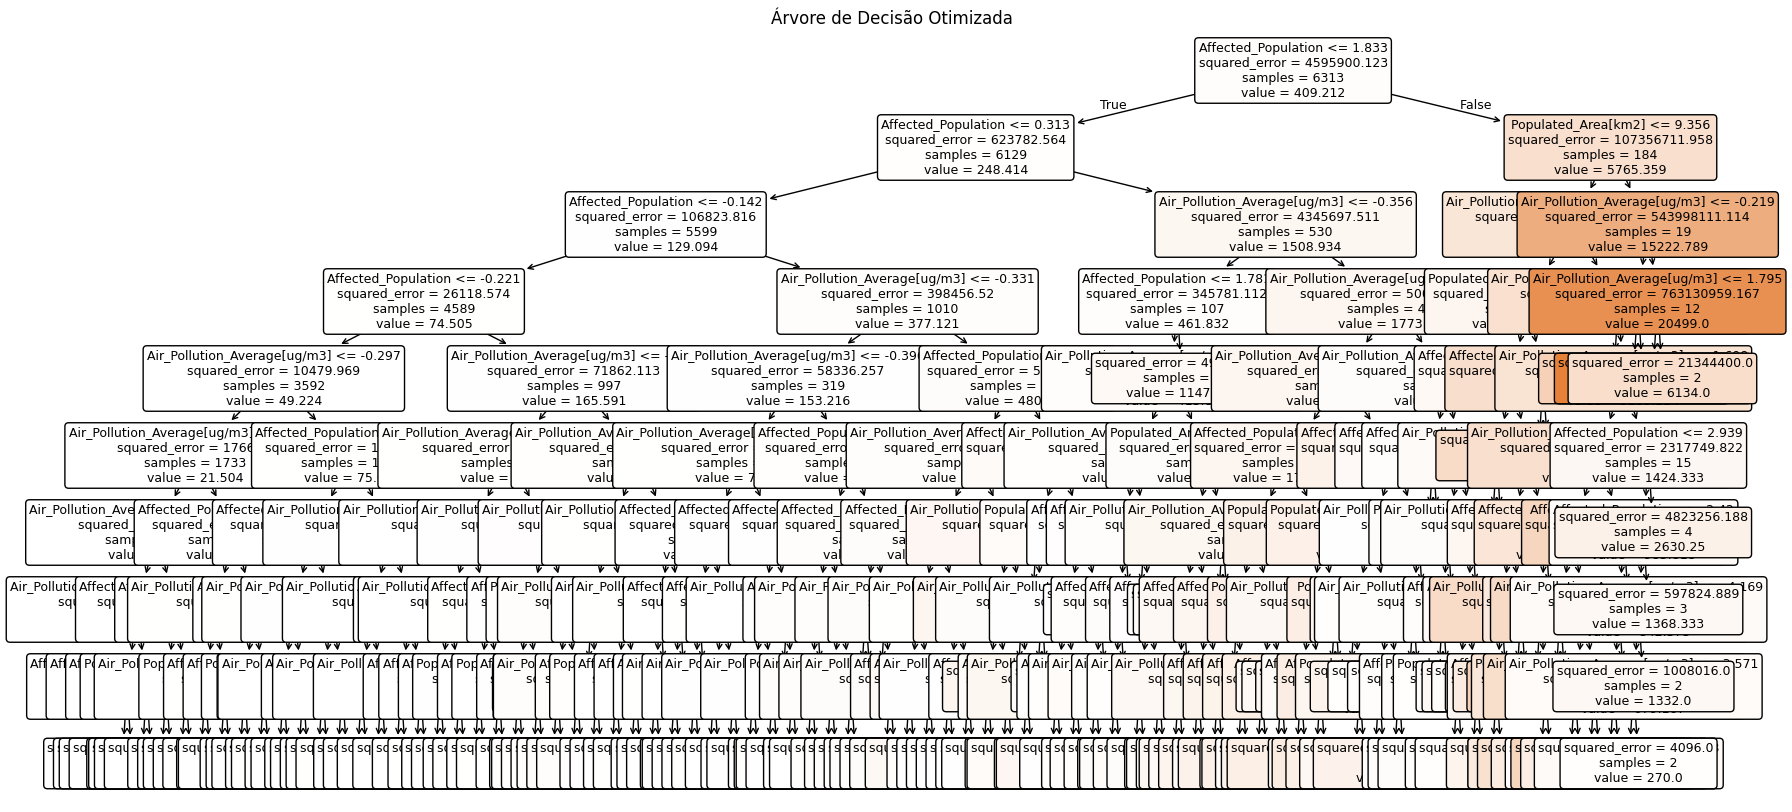

In [ ]:
best_tree = DecisionTreeRegressor(
    max_depth=9,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=random_state
)
best_tree.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
tree.plot_tree(
    best_tree,
    filled=True,
    feature_names=X_train.columns,
    rounded=True,
    fontsize=9
)
plt.title("Árvore de Decisão Otimizada")
plt.show()

#### Otimização do kernel SVM

In [ ]:
kernels = ['linear', 'rbf', 'poly']
results = []

for kernel in kernels:
    # initialize and train SVM
    svm_model = SVR(kernel=kernel)
    rmse_scores = cross_val_score(svm_model, X_train, y_train, scoring='neg_mean_squared_error', cv=20)
    # store results
    results.append({
        "model": kernel,
        "rmse": np.mean(rmse_scores),
        "std": np.std(rmse_scores)
    })

resdf = pd.DataFrame(results)
resdf = resdf.sort_values(by='rmse', ascending=True)
resdf

,model,rmse,std
1,rbf,-4.628436e+06,5.974894e+06
2,poly,-4.307128e+06,5.161684e+06
0,linear,-3.990279e+06,5.299262e+06


Com isto, vemos que o melhor kernel é o "rbf"
#### Otimização da configuração da rede neuronal

In [ ]:
def regressmodelevaluation(name_model, y_test, y_pred):
    mae = round(mean_absolute_error(y_test, y_pred), 3)
    mse = round(mean_squared_error(y_test, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    r2 = round(r2_score(y_test, y_pred), 3)
    mape = round(mean_absolute_percentage_error(y_test, y_pred), 3)
    return pd.Series({'Model': name_model, 'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape})

In [ ]:
results = []
ncols = X_train.shape[1]

for solv in ['lbfgs', 'sgd', 'adam']:
    for nodes in range(2,ncols):
        mlp = MLPRegressor(hidden_layer_sizes=nodes,
                           activation='tanh',
                           solver=solv,
                           max_iter=1000,
                           learning_rate='adaptive',
                           early_stopping=True,
                           random_state=random_state)
        mlp.fit(X_train, y_train)

        y_pred = mlp.predict(X_test)
        result = regressmodelevaluation(f'{solv} {nodes}', y_test, y_pred)
        results.append(result)
    
resdf = pd.DataFrame(results)
resdf

,Model,mae,mse,rmse,r2,mape
0,lbfgs 2,593.941,7495146.109,2737.726,0.092,1.297402e+17
1,sgd 2,477.940,7708266.922,2776.377,0.066,1.020709e+17
2,adam 2,453.225,8455178.998,2907.779,-0.025,2.439093e+14


In [ ]:
results = []
for solv in ['lbfgs', 'sgd', 'adam']:
    for nodes1 in range(2,6):
        for nodes2 in range(3,7):
            mlp = MLPRegressor(hidden_layer_sizes=(nodes1, nodes2),
                        activation='tanh',
                        solver=solv,
                        max_iter=1000,
                        learning_rate='adaptive',
                        early_stopping=True,
                        random_state=random_state)
            mlp.fit(X_train, y_train)

            y_pred = mlp.predict(X_test)
            result = regressmodelevaluation(f'{solv} {nodes1} {nodes2}', y_test, y_pred)
            results.append(result)
    
resdf = pd.DataFrame(results)
resdf.sort_values(by='r2', ascending=False)

,Model,mae,mse,rmse,r2,mape
10,lbfgs 4 5,564.981,6634056.208,2575.666,0.196,2.002603e+17
7,lbfgs 3 6,528.174,6792455.926,2606.234,0.177,1.100848e+17
27,sgd 4 6,500.758,6942985.060,2634.954,0.158,1.138653e+17
4,lbfgs 3 3,570.899,7306377.619,2703.031,0.114,2.066506e+17
3,lbfgs 2 6,547.130,7318503.798,2705.273,0.113,1.492466e+17
18,sgd 2 5,511.142,7349924.150,2711.074,0.109,9.364126e+16
9,lbfgs 4 4,543.044,7430539.571,2725.902,0.099,1.430968e+17
2,lbfgs 2 5,524.031,7442893.842,2728.167,0.098,7.579495e+16
20,sgd 3 3,514.020,7504409.096,2739.418,0.090,1.130998e+17
21,sgd 3 4,539.612,7508277.399,2740.124,0.090,1.383509e+17


Com isto, vemos que o melhor modelo é o lbfgs 4 5
#### k-fold cross validation

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)

models = []
models.append(('rgr', LinearRegression()))
models.append(('dtr', DecisionTreeRegressor(
        max_depth=9,
        min_samples_split=5,
        min_samples_leaf=1,
        random_state=random_state
    )))
models.append(('net', MLPRegressor(hidden_layer_sizes=(4, 5),
                        activation='tanh',
                        solver='lbfgs',
                        max_iter=1000,
                        learning_rate='adaptive',
                        early_stopping=True,
                        random_state=random_state)))
models.append(('svm', make_pipeline(StandardScaler(),SVR(kernel='rbf'))))

lstresults = []

for name, model in models:
    # RMSE
    mse_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    rmse_scores = (-mse_scores) ** 0.5

    # MAE
    mae_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
    mae_scores = -mae_scores

    # R2
    r2_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

    lstresults.append(pd.Series({
        'model': name,
        'mean_RMSE': round(np.mean(rmse_scores), 3),
        'std_RMSE': round(np.std(rmse_scores), 3),
        'mean_MAE': round(np.mean(mae_scores), 3),
        'std_MAE': round(np.std(mae_scores), 3),
        'mean_R2': round(np.mean(r2_scores), 3),
        'std_R2': round(np.std(r2_scores), 3)
    }))
    print(f"Model {name} done")

resdf = pd.DataFrame(lstresults)
resdf.sort_values(by='mean_R2', ascending=False)

Model rgr done
Model dtr done
Model net done
Model svm done


,model,mean_RMSE,std_RMSE,mean_MAE,std_MAE,mean_R2,std_R2
1,dtr,1878.710,262.839,406.658,14.255,0.320,0.144
0,rgr,1973.718,352.331,447.851,19.227,0.260,0.149
2,net,2332.775,501.497,618.084,26.906,-0.000,0.000
3,svm,2338.165,501.445,390.154,30.536,-0.005,0.003


### 4.3.1 Novo atributo "RespDisease"

In [7]:
dados4regioes = pd.concat([westEuDados, eastEuDados, soutEuDados, nortEuDados], ignore_index=False)
dados4regioes

,Country,NUTS_Code,Air_Pollutant,Disease,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Premature_Deaths
133,Austria,AT333,PM2.5,Chronic obstructive pulmonary disease,39690.0,387.5,5.0,0.0
141,Austria,AT321,PM2.5,Chronic obstructive pulmonary disease,16485.0,232.4,5.2,0.0
146,Austria,AT331,PM2.5,Chronic obstructive pulmonary disease,25349.0,227.4,5.0,0.0
152,Austria,AT321,PM2.5,Diabetes Mellitus,16485.0,232.4,5.2,0.0
164,Austria,AT331,PM2.5,Diabetes Mellitus,25349.0,227.4,5.0,0.0
...,...,...,...,...,...,...,...,...
46798,Sweden,SE213,NO2,Stroke,176161.0,5148.4,1.8,0.0
46799,Sweden,SE213,NO2,Stroke,176161.0,5148.4,1.8,0.0
46802,Sweden,SE313,NO2,Stroke,215667.0,4520.6,1.0,0.0
46803,Sweden,SE322,NO2,Stroke,100258.0,4104.6,0.6,0.0


Este código foi inspirado por esta [thread](https://stackoverflow.com/questions/67420811/a-new-column-in-pandas-which-value-depends-on-other-columns) no stack**overflow**

In [8]:
goalAttrib = 'RespDisease'

def calc_resp_disease(row):
    respDiseases = ['Asthma', 'Chronic obstructive pulmonary disease']
    if row['Disease'] in respDiseases:
        return 1
    else:
        return 0

dados4regioes[goalAttrib] = dados4regioes.apply(calc_resp_disease, axis=1)

dados4regioes

,Country,NUTS_Code,Air_Pollutant,Disease,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Premature_Deaths,RespDisease
133,Austria,AT333,PM2.5,Chronic obstructive pulmonary disease,39690.0,387.5,5.0,0.0,1
141,Austria,AT321,PM2.5,Chronic obstructive pulmonary disease,16485.0,232.4,5.2,0.0,1
146,Austria,AT331,PM2.5,Chronic obstructive pulmonary disease,25349.0,227.4,5.0,0.0,1
152,Austria,AT321,PM2.5,Diabetes Mellitus,16485.0,232.4,5.2,0.0,0
164,Austria,AT331,PM2.5,Diabetes Mellitus,25349.0,227.4,5.0,0.0,0
...,...,...,...,...,...,...,...,...,...
46798,Sweden,SE213,NO2,Stroke,176161.0,5148.4,1.8,0.0,0
46799,Sweden,SE213,NO2,Stroke,176161.0,5148.4,1.8,0.0,0
46802,Sweden,SE313,NO2,Stroke,215667.0,4520.6,1.0,0.0,0
46803,Sweden,SE322,NO2,Stroke,100258.0,4104.6,0.6,0.0,0


### 4.3.2 K-Fold cross validation

#### Preparação dos valores

In [ ]:
features = list(dados4regioes.columns[0:9])
numericFeatures = features[4:]
print(numericFeatures)

X = dados4regioes[numericFeatures].drop(columns=[goalAttrib])
y = dados4regioes[goalAttrib]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=random_state)

print("Stratified division of goal attribute:")
print(y_train.value_counts(normalize=True).mul(100).round(1).astype(str)+'%')
print(y_test.value_counts(normalize=True).mul(100).round(1).astype(str)+'%')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Premature_Deaths', 'RespDisease']
Stratified division of goal attribute:
RespDisease
0    62.1%
1    37.9%
Name: proportion, dtype: object
RespDisease
0    62.1%
1    37.9%
Name: proportion, dtype: object


#### Otimização dos parâmetros da Árvore de regressão

In [ ]:
results = []
for max_depth in range(2, 11):
    for min_samples_split in [2, 5, 10]:
        for min_samples_leaf in [1, 2, 4]:
            dt = DecisionTreeRegressor(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=random_state
            )
            dt.fit(X_train_scaled, y_train)
            y_pred = dt.predict(X_test_scaled)

            result = {
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'mse': mean_squared_error(y_test, y_pred),
                'r2': r2_score(y_test, y_pred)
            }
            results.append(result)

resdf = pd.DataFrame(results)
resdf = resdf.sort_values(by='r2', ascending=False)
resdf

,max_depth,min_samples_split,min_samples_leaf,mse,r2
73,10,2,2,0.150446,0.362745
76,10,5,2,0.150603,0.362081
79,10,10,2,0.150824,0.361144
75,10,5,1,0.150995,0.360419
72,10,2,1,0.151041,0.360228
...,...,...,...,...,...
4,2,5,2,0.179558,0.239434
5,2,5,4,0.179558,0.239434
6,2,10,1,0.179558,0.239434
7,2,10,2,0.179558,0.239434


Assim, vemos que a melhor árvore tem os seguintes parâmetros:
* max_depth = 10
* min_samples_split = 2
* min_samples_leaf = 2
#### Otimização do kernel SVM

In [ ]:
kernels = ['linear', 'rbf', #'poly'
           ]
results = []

for kernel in kernels:
    # initialize and train SVM
    svm_model = SVR(kernel=kernel)
    rmse_scores = cross_val_score(svm_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=10)
    # store results
    results.append({
        "model": kernel,
        "rmse": np.mean(rmse_scores),
        "std": np.std(rmse_scores)
    })
    print(f"{kernel} done")

resdf = pd.DataFrame(results)
resdf = resdf.sort_values(by='rmse', ascending=True)
resdf

linear done
rbf done


,model,rmse,std
0,linear,-0.255862,0.005808
1,rbf,-0.249676,0.006100


Comparando os valores, chegamos à conclusão que o melhor kernel é o "linear".
(O "poly" não foi mostrado visto que demora demasiado (mais de meia hora com cv=2))

#### Otimização da configuração da rede neuronal

In [ ]:
def regressmodelevaluation(name_model, y_test, y_pred):
    mae = round(mean_absolute_error(y_test, y_pred), 3)
    mse = round(mean_squared_error(y_test, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    r2 = round(r2_score(y_test, y_pred), 3)
    mape = round(mean_absolute_percentage_error(y_test, y_pred), 3)
    return pd.Series({'Model': name_model, 'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape})

In [ ]:
results = []
for solv in ['lbfgs', 'sgd', 'adam']:
    for nodes1 in range(2,6):
        for nodes2 in range(3,7):
            mlp = MLPRegressor(hidden_layer_sizes=(nodes1, nodes2),
                        activation='tanh',
                        solver=solv,
                        max_iter=1000,
                        learning_rate='adaptive',
                        early_stopping=True,
                        random_state=random_state)
            mlp.fit(X_train_scaled, y_train)

            y_pred = mlp.predict(X_test_scaled)
            result = regressmodelevaluation(f'{solv} {nodes1} {nodes2}', y_test, y_pred)
            results.append(result)
    
resdf = pd.DataFrame(results)
resdf.sort_values(by='r2', ascending=False)

C:\Users\35193\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\35193\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\35193\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lb

,Model,mae,mse,rmse,r2,mape
15,lbfgs 5 6,0.338,0.168,0.410,0.290,7.477506e+14
12,lbfgs 5 3,0.340,0.170,0.412,0.281,7.523330e+14
5,lbfgs 3 4,0.347,0.171,0.414,0.274,7.659550e+14
14,lbfgs 5 5,0.351,0.172,0.415,0.271,7.698458e+14
10,lbfgs 4 5,0.347,0.173,0.416,0.268,7.659608e+14
9,lbfgs 4 4,0.351,0.174,0.417,0.265,7.755926e+14
11,lbfgs 4 6,0.350,0.174,0.417,0.265,7.712404e+14
7,lbfgs 3 6,0.352,0.174,0.417,0.264,7.727748e+14
6,lbfgs 3 5,0.355,0.175,0.418,0.258,7.835596e+14
47,adam 5 6,0.355,0.176,0.420,0.254,7.887316e+14


Com isto, vemos que o melhor modelo é o lbfgs 5 6
#### Otimização da configuração dos K-vizinhos mais próximos

In [ ]:
num_holdouts = 20

results = []

for k in range(1, 51, 2):
    rmse_scores = []
    for _ in range(num_holdouts):
        Xhd_train, Xhd_test, yhd_train, yhd_test = train_test_split(X_train_scaled, y_train, test_size=test_size)

        knn_model = KNeighborsRegressor(n_neighbors=k)
        knn_model.fit(Xhd_train, yhd_train)

        y_pred = knn_model.predict(Xhd_test)

        mse = mean_squared_error(yhd_test, y_pred)
        rmse_scores.append(np.sqrt(mse))

    results.append({
        "k": k,
        "rmse_mean": np.mean(rmse_scores),
        "rmse_std": np.std(rmse_scores)
    })

resdf = pd.DataFrame(results)
resdf = resdf.sort_values(by='rmse_mean', ascending=True)
resdf

Average RMSE:

1 - 0.466 +/- (0.003)
3 - 0.424 +/- (0.003)
5 - 0.424 +/- (0.002)
7 - 0.423 +/- (0.002)
9 - 0.422 +/- (0.003)
11 - 0.421 +/- (0.002)
13 - 0.42 +/- (0.002)
15 - 0.419 +/- (0.002)
17 - 0.419 +/- (0.002)
19 - 0.418 +/- (0.002)
21 - 0.419 +/- (0.002)
23 - 0.419 +/- (0.002)
25 - 0.42 +/- (0.002)
27 - 0.42 +/- (0.002)
29 - 0.419 +/- (0.002)
31 - 0.42 +/- (0.003)
33 - 0.42 +/- (0.002)
35 - 0.419 +/- (0.002)
37 - 0.419 +/- (0.002)
39 - 0.42 +/- (0.002)
41 - 0.42 +/- (0.002)
43 - 0.42 +/- (0.002)
45 - 0.42 +/- (0.002)
47 - 0.42 +/- (0.002)
49 - 0.421 +/- (0.001)


k = 15 é o ideal aqui (?)

#### k-fold cross validation

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)

models = []
#models.append(('rgr', LinearRegression()))
models.append(('dtr', DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=2,
        random_state=random_state
    )))
models.append(('net', MLPRegressor(hidden_layer_sizes=(5, 6),
                        activation='tanh',
                        solver='lbfgs',
                        max_iter=1000,
                        learning_rate='adaptive',
                        early_stopping=True,
                        random_state=random_state)))
models.append(('knn', KNeighborsRegressor(n_neighbors=21)))
models.append(('svm', make_pipeline(StandardScaler(),SVR(kernel='linear'))))

lstresults = []

for name, model in models:
    # RMSE
    mse_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    rmse_scores = (-mse_scores) ** 0.5

    # MAE
    mae_scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
    mae_scores = -mae_scores

    # R2
    r2_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

    lstresults.append(pd.Series({
        'model': name,
        'mean_RMSE': round(np.mean(rmse_scores), 3),
        'std_RMSE': round(np.std(rmse_scores), 3),
        'mean_MAE': round(np.mean(mae_scores), 3),
        'std_MAE': round(np.std(mae_scores), 3),
        'mean_R2': round(np.mean(r2_scores), 3),
        'std_R2': round(np.std(r2_scores), 3)
    }))
    print(f"Model {name} done")

resdf = pd.DataFrame(lstresults)
resdf.sort_values(by='mean_R2', ascending=False)

Model dtr done
Model net done
Model knn done
Model svm done


,model,mean_RMSE,std_RMSE,mean_MAE,std_MAE,mean_R2,std_R2
0,dtr,0.385,0.002,0.288,0.002,0.371,0.005
2,knn,0.450,0.003,0.387,0.002,0.139,0.005
1,net,0.485,0.002,0.471,0.001,-0.000,0.000
3,svm,0.506,0.006,0.346,0.006,-0.087,0.020
